In [1]:
from typing import  List, Literal
import pandas as pd
from src.pipe_store import *
from lifelines import  KaplanMeierFitter
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
path = '~/Repos/STRIDE/STRIDE-Analytics/data/20210614-mismatch_ep_db-extended.pickle'
donor_type ='Deceased'
status = 'All'

df = (
    data_loading(path)
    .pipe(start_pipeline, status, donor_type)
    .pipe(keeping_features,
        'Failure',
        'Survival[Y]',
        'EpvsHLA_Donor',
        '#DESA',
        'DESA', 
    )
    .pipe(set_time_event_label, E='Failure', T='Survival[Y]')
    .pipe(setting_prediction_horizon, 15)
)
epitope_path = '~/UMCUtrecht/EpitopevsHLA.pickle'
epitope_db = pd.read_pickle(epitope_path)

Step: data_loading | Shape: (4690, 24) | Computation Time: 0.018983s
- selceted cohort --> Donor Type: Deceased, Epitope Antibody Presence: All
Step: start_pipeline | Shape: (3235, 23) | Computation Time: 0.015387s
Step: set_time_event_label | Shape: (3235, 5) | Computation Time: 0.001912s
Step: setting_prediction_horizon | Shape: (3235, 5) | Computation Time: 0.002769s


In [3]:
epitope_db.sample()

,Epitope,ElliPro Score,PolymorphicResidues,AntibodyReactivity,Luminex Alleles,All Alleles,distance [A],mean_distance [A],std_distance [A],mAb,Location,isotype
331,140TV,High,"[(140, T), (142, V)]",unknown,"{DRB1*08:02, DRB1*10:01, DRB1*14:01, DRB1*11:0...","{DRB1*11:24, DRB1*04:43, DRB1*08:03, DRB1*11:4...","{'DRB1*14:04': 19.209, 'DRB1*14:54': 19.21, 'D...",19.481125,0.456564,unknown,"{'DRB1*14:03': [52.9, -24.22, -18.14], 'DRB1*1...",unknown


In [4]:
def get_epitopes_ellipro_scores(df, scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
    if not scores:
        scores = ['Very Low', 'Low', 'Intermediate', 'High']
    score_epitope = {score : set(df[df['ElliPro Score'] == score].Epitope.values) for score in scores}
    assert len(df) == sum([len(score_epitope[item]) for item in score_epitope])
    return score_epitope

def categorizer(epitopes, ellipro_cat_epitopes, output:Literal['#Epitope', 'Epitope']='Epitope'):
    if epitopes and (intersect := epitopes.intersection(ellipro_cat_epitopes)):
        return {'#Epitope': len(intersect), 'Epitope': intersect}.get(output)
    return 0


def categorize_per_elliproscore(df, 
    score_vs_ep:dict,
    output:Literal['Number', 'Epitope']='Epitope',
    scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
    df = df.copy(deep=True)
    if not scores:
        scores = ['Very Low', 'Low', 'Intermediate', 'High']
    for score in scores:
        df[score] = df['DESA'].apply(categorizer, args=(score_vs_ep[score], output,))
    return df
    
# def plot_km_curves_elliproscore(df, scores:List[Literal['Very Low', 'Low', 'Intermediate', 'High']]=None):
#      if not scores:
#         scores = ['Very Low', 'Low', 'Intermediate', 'High']
#     km = [KaplanMeierFitter() for len(scores)]


In [5]:
score_vs_ep = get_epitopes_ellipro_scores(epitope_db)

In [6]:
df_new = categorize_per_elliproscore(df, score_vs_ep, output='#Epitope')

In [7]:

print('Very Low', df_new['Very Low'].apply(lambda x: 1 if x else 0).sum())
print('Low', df_new['Low'].apply(lambda x: 1 if x else 0).sum())
print('Intermediate', df_new['Intermediate'].apply(lambda x: 1 if x else 0).sum())
print('High', df_new['High'].apply(lambda x: 1 if x else 0).sum())

Very Low 82
Low 110
Intermediate 182
High 296


# Plot Heatmap

In [8]:
scores = ['Very Low', 'Low', 'Intermediate', 'High']
cols = scores + ['#DESA', 'T', 'E']
df_new_desa = df_new[df_new['#DESA'] != 0][cols]
# def heatmap_ellipros(df, scores):
df_new_desa = df_new_desa.sort_values(by=['T'])
df_new_desa[scores] = df_new_desa[scores].div(df_new_desa['#DESA'], axis=0)

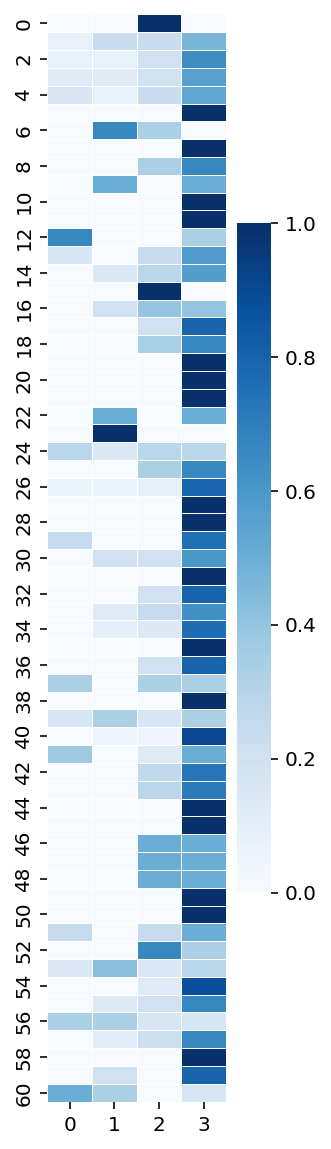

In [9]:
import seaborn as sns
plt.figure(figsize=(2, 10))
plot_values = df_new_desa[(df_new_desa['E'] == 1) & (df_new_desa['T'] < 1)][scores].values
ax = sns.heatmap(plot_values, linewidth=0.5, cmap='Blues')
plt.show()

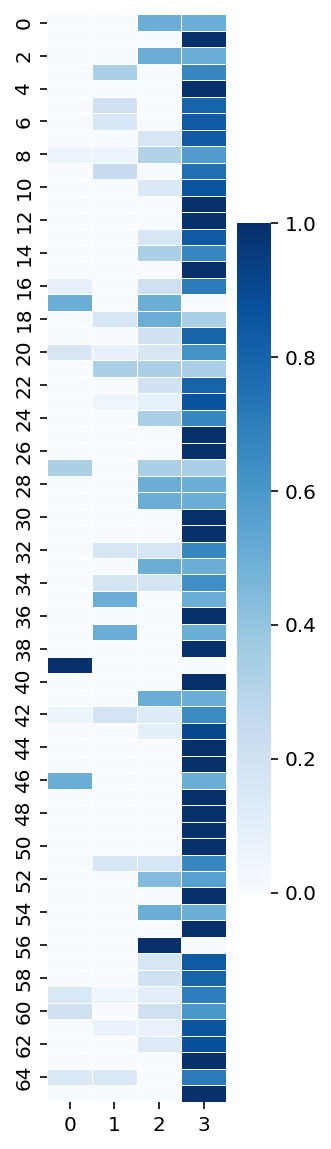

In [12]:
import seaborn as sns
plt.figure(figsize=(2, 10))
plot_values = df_new_desa[(df_new_desa['E'] == 0) & (df_new_desa['T'] > 12)][scores].values
ax = sns.heatmap(plot_values, linewidth=0.5, cmap='Blues')
plt.show()

# Plot Kaplan-Meier Curves

In [62]:
df_new['#DESA'].apply(lambda x: 1 if x else 0).sum()

315